## <center> **Bank Customer Churn Prediction** </center>

**Objective:**
<br> Given a Bank’s customer information, can we build a classifier which can
determine whether they will leave or not? <br>

**Context:**
<br> Businesses like banks which provide service have to worry about problem
of 'Churn' i.e. customers leaving and joining another service provider. It is
important to understand which aspects of the service influence a
customer's decision in this regard. Management can concentrate efforts
on improvement of service, keeping in mind these priorities. <br>

**Data Description:**
<br> The dataset contains 10,000 sample points with 14 distinct features such
as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance
etc. Know your data: https://www.kaggle.com/barelydedicated/bankcustomer-
churn-modeling

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

tf.random.set_seed(42)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve, roc_auc_score

import keras

import warnings
warnings.filterwarnings('ignore')

2.1.0-rc1


Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### **Read data and load it in dataframe:**

In [0]:
cus_df = pd.read_csv('gdrive/My Drive/bank.csv')

In [5]:
cus_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### **Check dataset shape:**

In [6]:
cus_df.shape

(10000, 14)

As seen, data has 10,000 rows and 14 columns

### **Drop columns:**

We can drop RowNumber, CustomerId & Surname as they will not be much useful for model building

In [7]:
cus_df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
cus_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### **Check for missing values:**

In [8]:
cus_df.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No missing values, so we are good to proceed

### **Check for Outliers:**

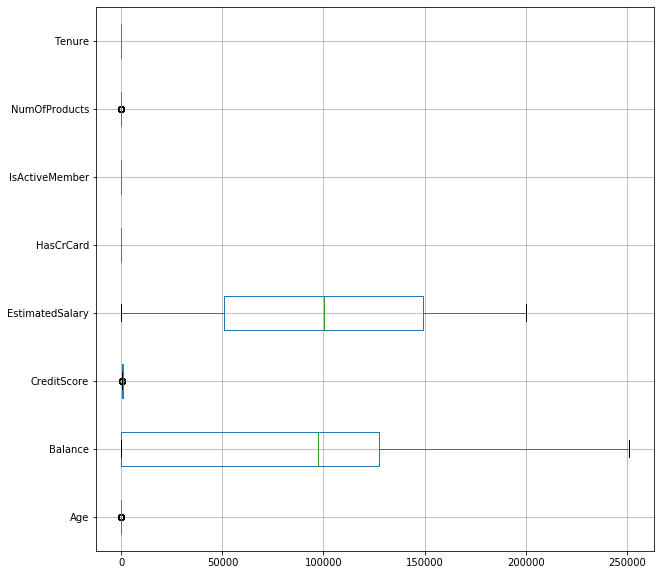

In [9]:
cols = list(cus_df.columns.difference(["Exited", "Geography", "Gender"]))
cus_df.boxplot(column=cols, vert=False, figsize=(10,10))

Looks like outliers are present in NumofProducts, CreditScore, Age columns. We will have to handle outliers in CreditScore column alone.

**View Outliers in CreditScore column:**

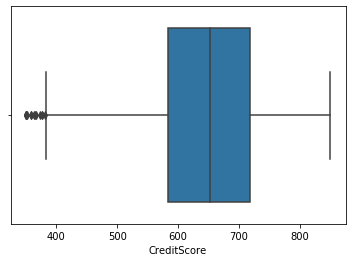

In [10]:
sns.boxplot(cus_df['CreditScore'])

**Handling Outliers:**

In [0]:
def handle_outlier(df, col):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = 1.5*(Q3 - Q1)
  min = Q1 - IQR
  max = Q3 + IQR

  print('Count of outliers in ', col, 'before handling:')
  print(df[(df[col] < min ) | (df[col] > max)][col].count())

  df.loc[df[col] < min, col] = min
  df.loc[df[col] > max, col] = max

  print('Count of outliers in ', col, 'after handling:')
  print(df[(df[col] < min ) | (df[col] > max)][col].count())

In [12]:
handle_outlier(cus_df, 'CreditScore')

Count of outliers in  CreditScore before handling:
15
Count of outliers in  CreditScore after handling:
0


**View Outliers in CreditScore column after handling:**

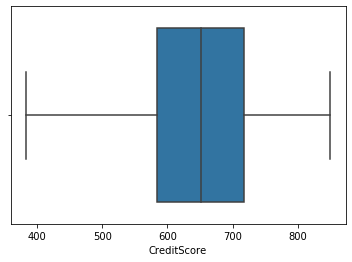

In [13]:
sns.boxplot(cus_df['CreditScore'])

We have handled the outliers and so we are good to proceed now

## **Some more analysis on the data:**

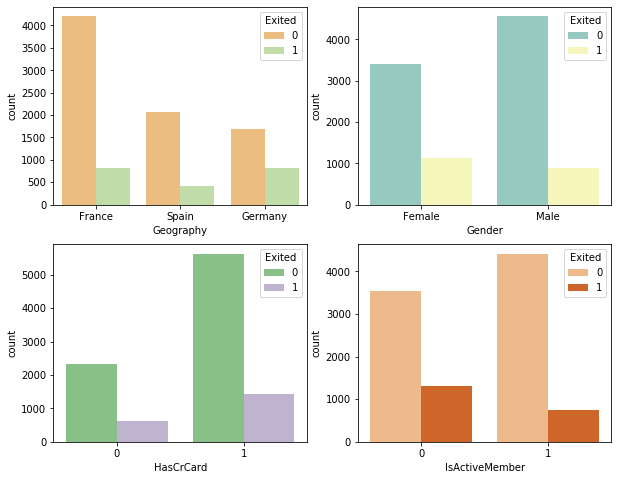

In [14]:
fig, axarr = plt.subplots(2, 2, figsize=(10, 8))
sns.countplot(x='Geography', hue = 'Exited',data = cus_df, palette='Spectral', ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = cus_df, palette='Set3', ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = cus_df, palette='Accent', ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = cus_df, palette='Oranges', ax=axarr[1][1])

**Inference:**

- Majority of the data is from persons from France.
- Female customers are lesser compared to male customers
- Majority of the customers that churned have credit cards.
- Inactive customers have a higher churn rate.

## **Check data distribution under each target label:**

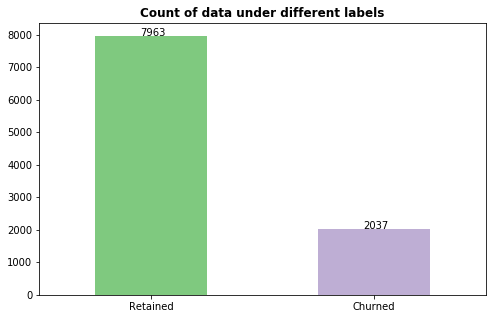

In [15]:
plt.subplots(figsize=(8,5)) 

labels = ["Retained", "Churned"]
xlabels = [i for i in labels]

ax = cus_df['Exited'].value_counts().plot.bar(color=sns.color_palette('Accent',20))
ax.set_title('Count of data under different labels', fontweight = 'bold')
ax.set_xticklabels(xlabels, rotation=0)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+.2,p.get_height()+1))

As seen, Customers retained with the bank are greater than Churned customers. So our model would be biased towards predicting retained customers than predicting the churned people.

### **Check dataset info:**

In [16]:
cus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null float64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


As seen, Geography and Gender columns are not numeric. So we will need to encode and make them numeric

### **Encoding categorical features:**

Let's find the unique values present in these columns, before choosing the type of encoder

In [17]:
cus_df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [18]:
cus_df['Gender'].unique()

array(['Female', 'Male'], dtype=object)

Since both the features have totally 5 unique values, we can use get_dummies to encode them

In [19]:
cus_df = pd.get_dummies(cus_df, drop_first=True)
cus_df.shape

(10000, 12)

In [20]:
cus_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619.0,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608.0,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502.0,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699.0,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850.0,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [21]:
cus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null float64
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


Categorical features have been converted to numeric after encoding. We are good to proceed now	

### **Let's view the data distributions:**

In [22]:
cus_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.561300,96.558702,383.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00
Geography_Germany,10000.0,0.250900,0.433553,0.00,0.00,0.000,1.0000,1.00


Looks like Balance is negatively skewed. Other features look to be almost normal

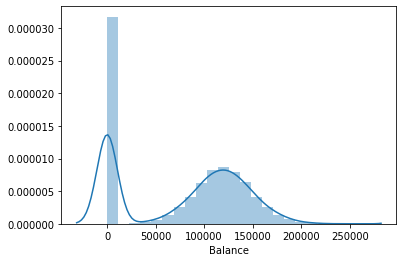

In [23]:
sns.distplot(cus_df['Balance'])

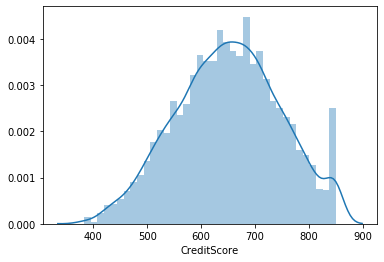

In [24]:
sns.distplot(cus_df['CreditScore'])

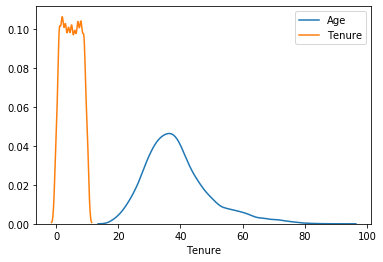

In [25]:
for col in ['Age', 'Tenure']:
  sns.distplot(cus_df[col], hist=False, label=col)

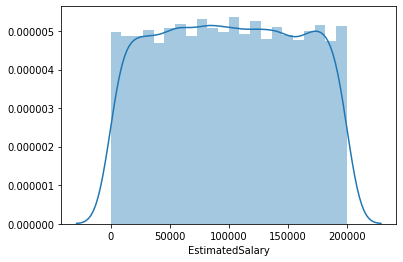

In [26]:
sns.distplot(cus_df['EstimatedSalary'])

### **Let's see how many customers are active:**

In [27]:
cus_df['IsActiveMember'].value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

5151 customers are active

**Checking different combinations of active members and people who exited:**

In [28]:
# Active customers who are churned:
cus_df[(cus_df['IsActiveMember'] == 1)  & (cus_df['Exited'] == 1)].count()[0]

735

In [29]:
# Inactive customers who are with the bank:
cus_df[(cus_df['IsActiveMember'] == 0)  & (cus_df['Exited'] == 0)].count()[0]

3547

In [30]:
# Active customers who are with the bank:
cus_df[(cus_df['IsActiveMember'] == 1)  & (cus_df['Exited'] == 0)].count()[0]

4416

In [31]:
# Inactive customers who are churned:
cus_df[(cus_df['IsActiveMember'] == 0)  & (cus_df['Exited'] == 1)].count()[0]

1302

### **Pair plot Analysis:**

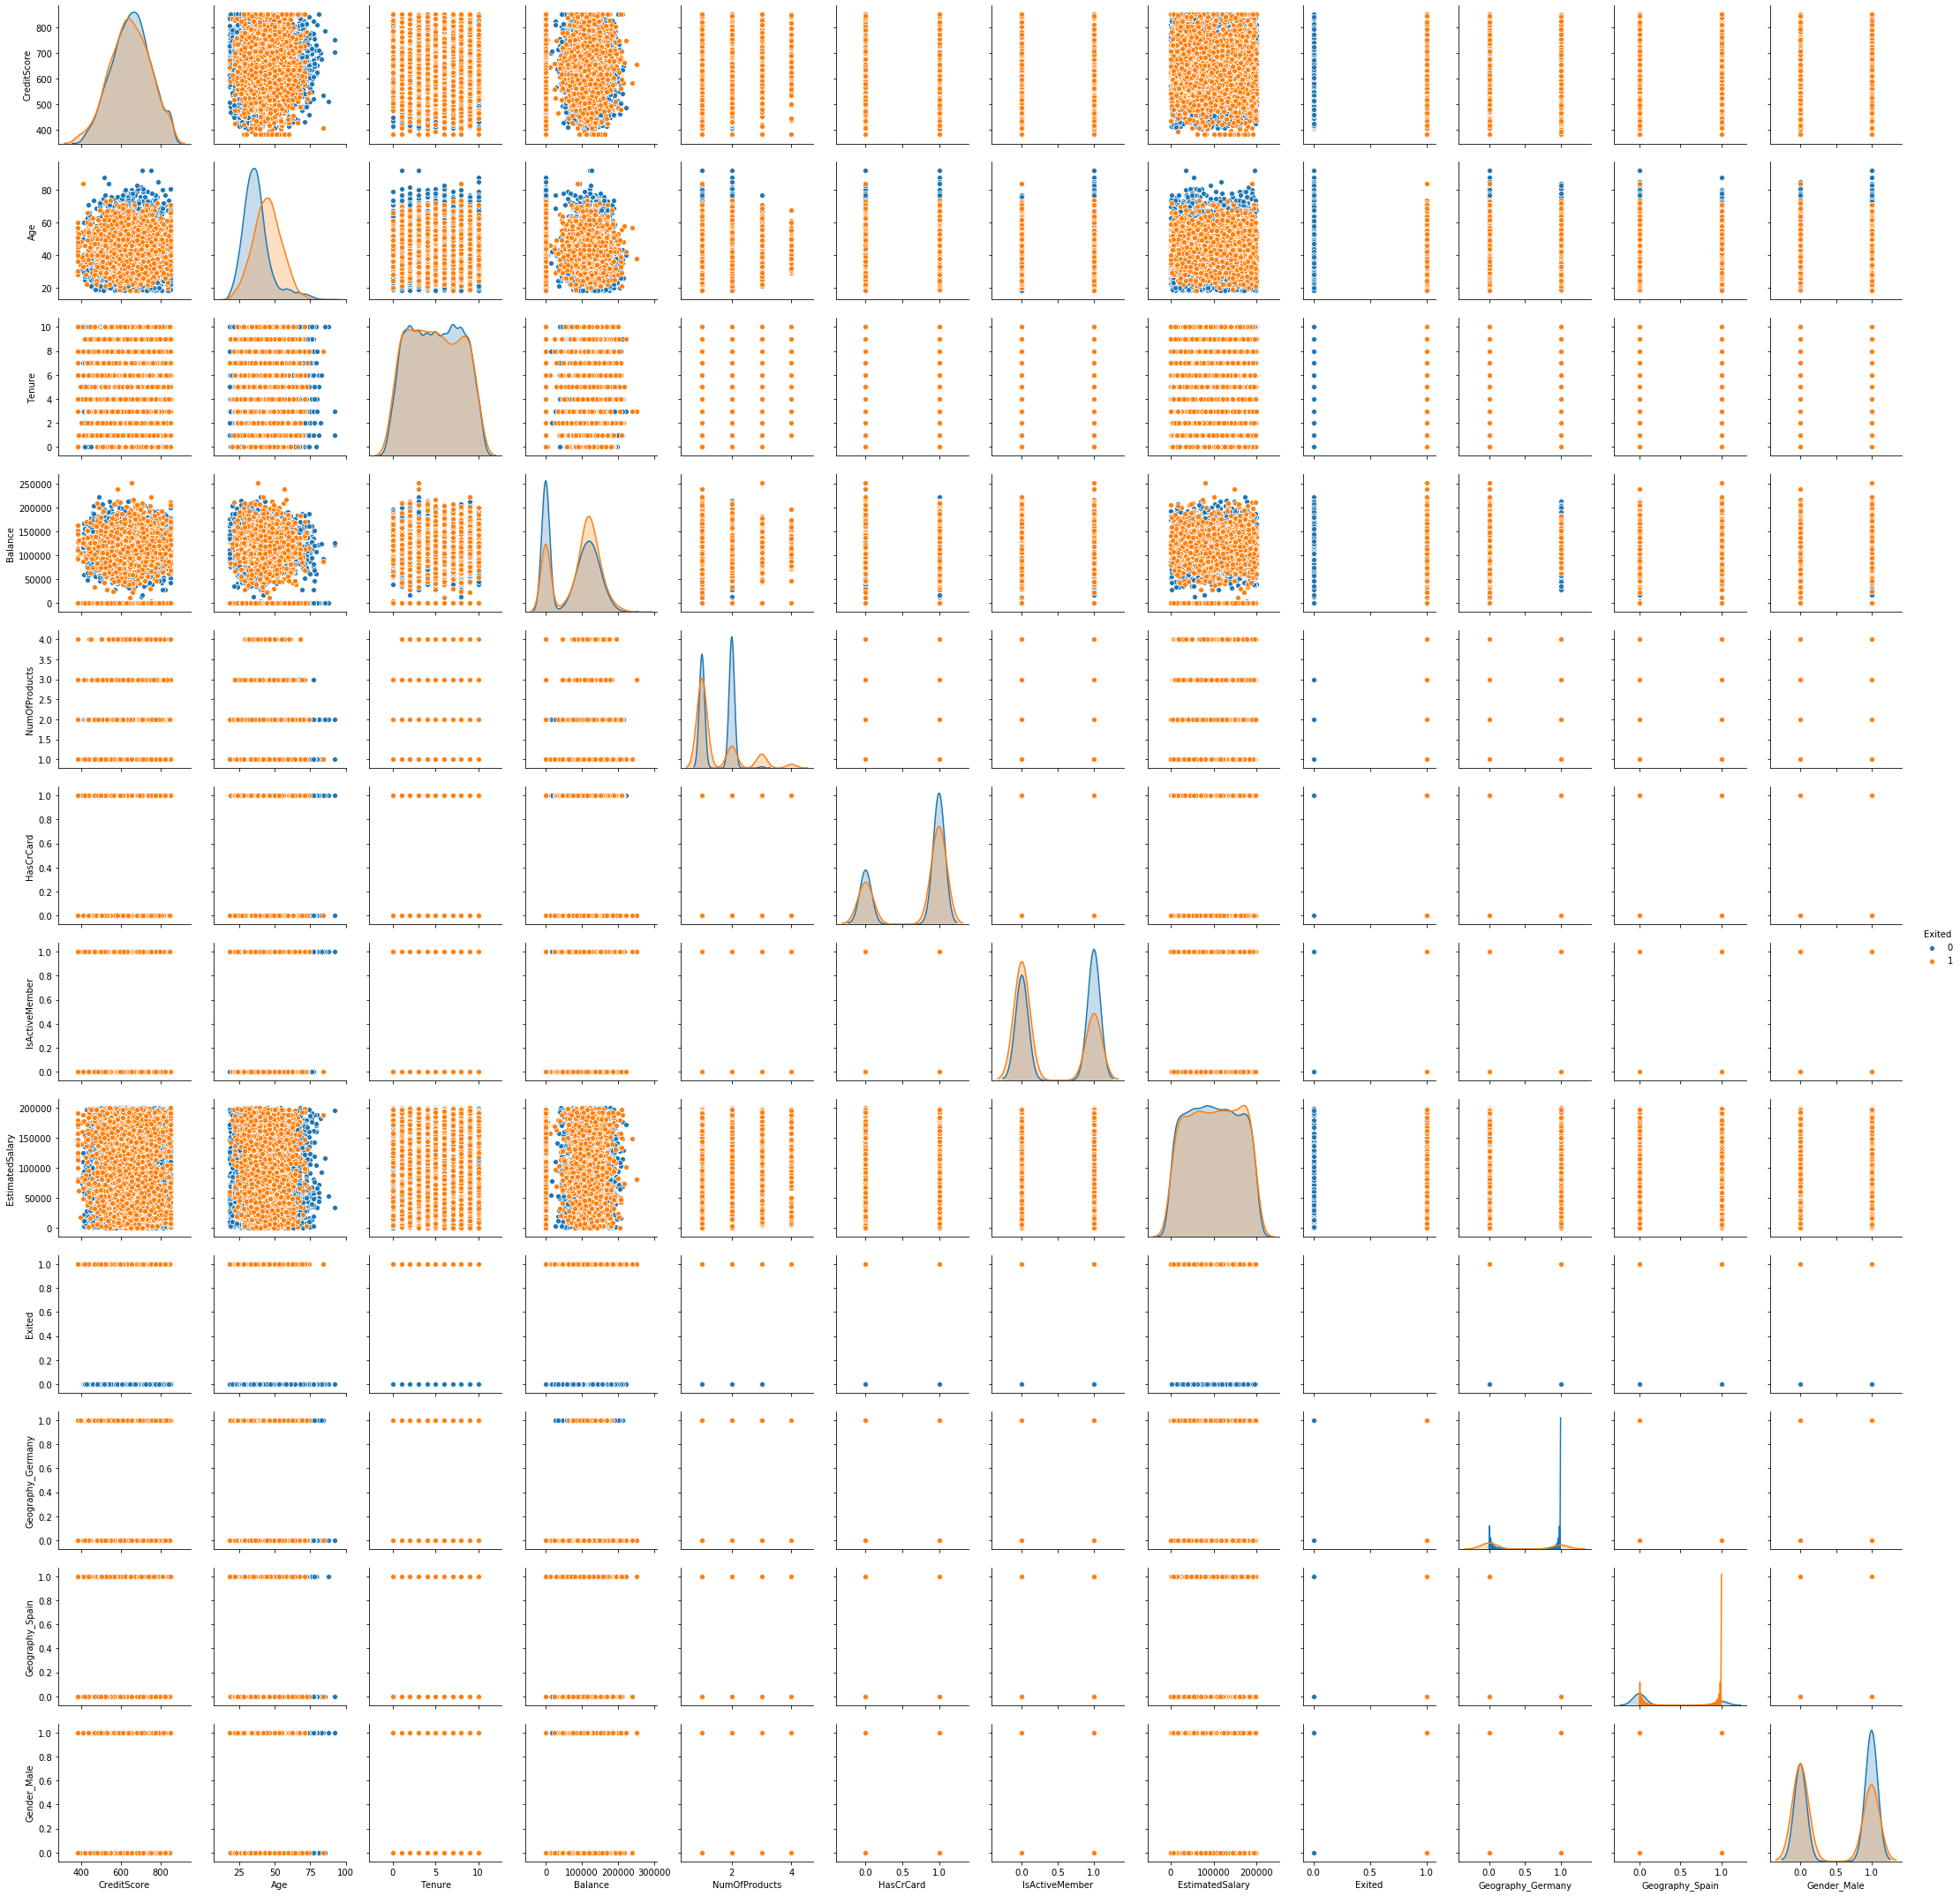

In [32]:
sns.pairplot(cus_df, hue="Exited", diag_kind="kde")

## **Checking correlation using heatmap:**

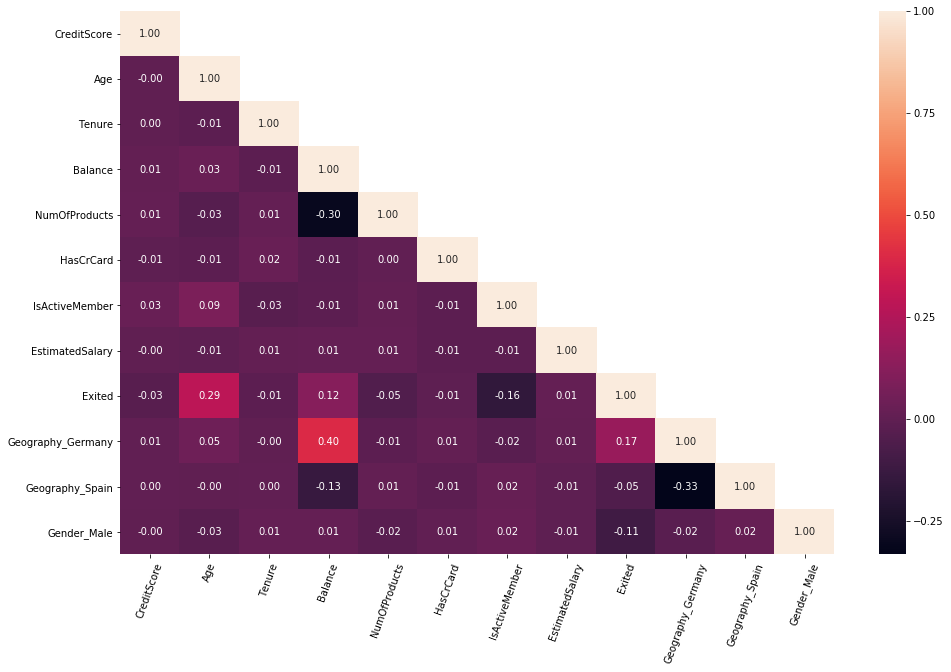

In [33]:
plt.figure(figsize=(16,10))
mask = np.zeros_like(cus_df.corr())
mask[np.triu_indices_from(mask, 1)] = True
a = sns.heatmap(cus_df.corr(), mask=mask, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=70)

Correlation between independent variables is very minimal which is good for model building

**Let's check the correlation with the target:**

In [34]:
corr_with_target = pd.DataFrame(cus_df.corr().abs().loc['Exited'])
corr_with_target.drop('Exited',axis=0,inplace=True) # Drop target as we know self correlation would be 1
corr_with_target.rename(columns={'Exited': 'Corr value'}, inplace=True)

corr_with_target.sort_values(by='Corr value',ascending=False)

,Corr value
Age,0.285323
Geography_Germany,0.173488
IsActiveMember,0.156128
Balance,0.118533
Gender_Male,0.106512
Geography_Spain,0.052667
NumOfProducts,0.047820
CreditScore,0.026455
Tenure,0.014001
EstimatedSalary,0.012097


Features aren't much correlated with the target as well

## **Splitting data into train & test:**

In [0]:
X = cus_df.drop('Exited', axis=1)
y = cus_df['Exited']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

## **Standardizing the train & test data:**

We will standardize the train & test data separately so as to avoid data leakage

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.fit_transform(X_test)

**View standardized train data:**

In [38]:
X_train[0,]

array([ 2.05616423, -0.09047572, -1.04410847, -1.21389222,  0.78764476,
        0.63998842, -1.03223352, -1.58012433, -0.57625055, -0.57251144,
       -1.10394768])

**View standardized test data:**

In [39]:
X_test[0,]

array([ 2.08801505,  0.50560079, -0.01988846,  0.81624324, -0.89154118,
       -1.51429341,  0.97367959,  1.22026383,  1.71076052, -0.57683707,
       -1.07767494])

## **Model Building:**

## **Model 1:**

In [0]:
# Initialize the sequential model:
model1 = tf.keras.models.Sequential()

# Adding the input layer and the first hidden layer with activation as relu:
model1.add(tf.keras.layers.Dense(6, input_dim = 11, activation='relu'))

# Adding the second hidden layer:
model1.add(tf.keras.layers.Dense(6, activation='relu'))

# Adding output Layer:
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model:
model1.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

**View summary - Model1:**

In [41]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


**Run the model:**

In [42]:
model1.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 0)

**Predict the results using 0.5 as a threshold and print accuracy:**

In [43]:
# Accuracy on train data:
score, acc = model1.evaluate(X_train, y_train, batch_size=10)
print('Train accuracy: ', acc)

# Predict the results using 0.5 as a threshold:
y_pred = np.where(model1.predict(X_test) > 0.5, 1, 0)

# Accuracy on test data:
score, acc = model1.evaluate(X_test, y_test, batch_size=10)
print('Test accuracy: ', acc)

# Confusion matrix:
cm_model1 = confusion_matrix(y_test, y_pred)
print('Confusion matrix: \n', cm_model1)

7000/7000 [==============================] - 1s 113us/sample - loss: 0.3271 - accuracy: 0.8654
Train accuracy:  0.86542857
3000/3000 [==============================] - 0s 103us/sample - loss: 0.3592 - accuracy: 0.8513
Test accuracy:  0.8513333
Confusion matrix: 
 [[2289   91]
 [ 355  265]]


**Plotting Confusion matrix for model1:**

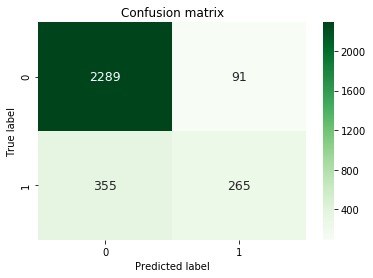

In [44]:
plt.figure(figsize=(6,4))
sns.heatmap(pd.DataFrame(cm_model1), annot=True, annot_kws={"fontsize":12.5}, cmap='Greens', fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Analyzing confusion matrix:**

In test data, totally we have 3000 datapoints <br>
Sum of all values in confusion matrix is equal to 3000

- We correctly predicted that 2289 customers are retained with the bank
- We correctly predicted that 265 customers are churned
- We incorrectly predicted 355 customers as retained whereas they are actually churned 
- We incorrectly predicted 91 customers as churned whereas in reality they are still with the bank

**Classification report - Model1:**

In [45]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2380
           1       0.74      0.43      0.54       620

    accuracy                           0.85      3000
   macro avg       0.81      0.69      0.73      3000
weighted avg       0.84      0.85      0.84      3000



**ROC - AUC:**

In [46]:
y_predictprob = model1.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predictprob)

roc_auc = auc(fpr, tpr)
print('\033[1mArea under the ROC curve:\033[0m %3.2f' %(roc_auc))

Area under the ROC curve: 0.85


**Plotting ROC curve:**

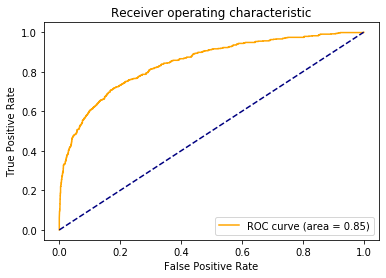

In [47]:
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## **Optimize model using batch normalization:**

## **Model 2:**

In [0]:
# Initialize the sequential model:
model2 = tf.keras.models.Sequential()

# Adding the input layer and the first hidden layer with activation as relu:
model2.add(tf.keras.layers.Dense(6, input_dim = 11, activation='relu'))

# Adding the batch normalization layer:
model2.add(tf.keras.layers.BatchNormalization())

# Adding the second hidden layer:
model2.add(tf.keras.layers.Dense(6, activation='relu'))

# Adding output Layer:
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model:
model2.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

**View summary - Model2:**

In [49]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6)                 72        
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 145
Trainable params: 133
Non-trainable params: 12
_________________________________________________________________
None


**Run the model:**

In [50]:
model2.fit(X_train, y_train, batch_size = 10, epochs = 100, verbose = 0)

**Predict the results using 0.5 as a threshold and print accuracy:**

In [51]:
# Accuracy on train data:
score, acc = model2.evaluate(X_train, y_train, batch_size=10)
print('Train acc: ', acc)

# Predict the results using 0.5 as a threshold:
y_pred = np.where(model2.predict(X_test) > 0.5, 1, 0)

# Accuracy on test data:
score, acc = model2.evaluate(X_test, y_test, batch_size=10)
print('Test acc: ', acc)

# Confusion matrix:
cm_model2 = confusion_matrix(y_test, y_pred)
print('Confusion matrix: \n', cm_model2)

7000/7000 [==============================] - 1s 122us/sample - loss: 0.3273 - accuracy: 0.8674
Train acc:  0.8674286
3000/3000 [==============================] - 0s 117us/sample - loss: 0.3540 - accuracy: 0.8523
Test acc:  0.8523333
Confusion matrix: 
 [[2266  114]
 [ 329  291]]


**Plotting Confusion matrix for model2:**

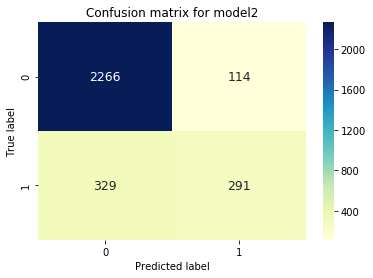

In [52]:
plt.figure(figsize=(6,4))
sns.heatmap(pd.DataFrame(cm_model2), annot=True, annot_kws={"fontsize":12.5}, cmap='YlGnBu', fmt='d')
plt.title('Confusion matrix for model2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Analyzing confusion matrix:**

In test data, totally we have 3000 datapoints <br>
Sum of all values in confusion matrix is equal to 3000

- We correctly predicted that 2266 customers are retained with the bank
- We correctly predicted that 291 customers are churned
- We incorrectly predicted 329 customers as retained whereas they are actually churned 
- We incorrectly predicted 114 customers as churned whereas in reality they are still with the bank

**Classification report for model2:**

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      2380
           1       0.72      0.47      0.57       620

    accuracy                           0.85      3000
   macro avg       0.80      0.71      0.74      3000
weighted avg       0.84      0.85      0.84      3000



**ROC - AUC:**

In [54]:
y_predictprob = model2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predictprob)

roc_auc = auc(fpr, tpr)
print('\033[1mArea under the ROC curve:\033[0m %3.2f' %(roc_auc))

Area under the ROC curve: 0.85


**Plotting ROC curve:**

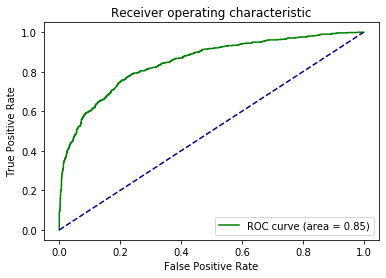

In [55]:
plt.plot(fpr, tpr, color='Green', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## **More hidden layers & learning rate:**

## **Model 3:**

In [0]:
# Initialize the sequential model:
model3 = tf.keras.models.Sequential()

# Adding the input layer and the first hidden layer with activation as relu:
model3.add(tf.keras.layers.Dense(6, input_dim = 11, activation='relu'))

# Adding batch normalization layer:
model3.add(tf.keras.layers.BatchNormalization())

# Adding the second hidden layer:
model3.add(tf.keras.layers.Dense(12, activation='relu'))

# Adding the third hidden layer:
model3.add(tf.keras.layers.Dense(18, activation='relu'))

# Adding output Layer:
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model:
model3.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

**View Summary - Model3**

In [57]:
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6)                 72        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_7 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_8 (Dense)              (None, 18)                234       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 19        
Total params: 433
Trainable params: 421
Non-trainable params: 12
_________________________________________________________________
None


**Run the model:**

In [58]:
model3.fit(X_train, y_train, epochs=500, verbose=0)

**Predict the results using 0.5 as a threshold and print accuracy:**

In [59]:
# Accuracy on train data:
score, acc = model3.evaluate(X_train, y_train, batch_size=10)
print('Train acc: ', acc)

# Predict the results using 0.5 as a threshold:
y_pred = np.where(model3.predict(X_test) > 0.5, 1, 0)

# Accuracy on test data:
score, acc = model3.evaluate(X_test, y_test, batch_size=10)
print('Test acc: ', acc)

# Confusion matrix:
cm_model3 = confusion_matrix(y_test, y_pred)
print('Confusion matrix: \n', cm_model3)

7000/7000 [==============================] - 1s 124us/sample - loss: 0.3113 - accuracy: 0.8723
Train acc:  0.8722857
3000/3000 [==============================] - 0s 116us/sample - loss: 0.3606 - accuracy: 0.8563
Test acc:  0.8563333
Confusion matrix: 
 [[2292   88]
 [ 343  277]]


**Plotting Confusion matrix for model3:**

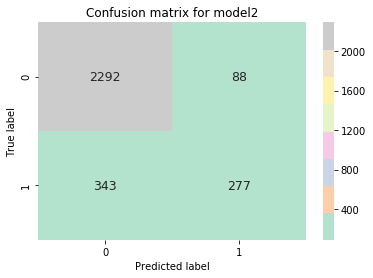

In [60]:
plt.figure(figsize=(6,4))
sns.heatmap(pd.DataFrame(cm_model3), annot=True, annot_kws={"fontsize":12.5}, cmap='Pastel2', fmt='d')
plt.title('Confusion matrix for model2')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Analyzing confusion matrix:**

In test data, totally we have 3000 datapoints <br>
Sum of all values in confusion matrix is equal to 3000

- We correctly predicted that 2292 customers are retained with the bank
- We correctly predicted that 277 customers are churned
- We incorrectly predicted 343 customers as retained whereas they are actually churned 
- We incorrectly predicted 88 customers as churned whereas in reality they are still with the bank

**Classification report for model3:**

In [61]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2380
           1       0.76      0.45      0.56       620

    accuracy                           0.86      3000
   macro avg       0.81      0.70      0.74      3000
weighted avg       0.85      0.86      0.84      3000



**ROC - AUC:**

In [62]:
y_predictprob = model3.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predictprob)

roc_auc = auc(fpr, tpr)
print('\033[1mArea under the ROC curve:\033[0m %3.2f' %(roc_auc))

Area under the ROC curve: 0.85


**Plotting ROC curve:**

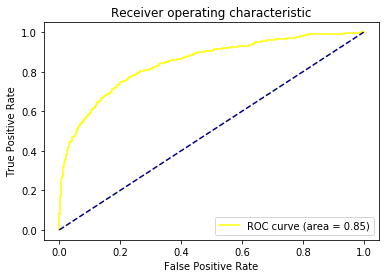

In [63]:
plt.plot(fpr, tpr, color='Yellow', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

## **Overall Summary:**

- Read the bank customer data. It had 10,000 rows and 14 columns
- Dropped the unique value columns like RowNumber, CustomerId & Surname from data.
- Data didn't have any missing values.
- Outliers were present in columns NumofProducts, CreditScore, Age. Handled outliers only for CreditScore column.
- Encoded categorical data such as Geopgraphy and Gender
- Performed certain data visualizations to understand the distribution and correlation 
- Data was split into train and test and then was standardized before applying the model
- Model 1 was built, which is a simple sequential model with one hidden layer. It gave an auc of 0.85 on the test data
- Model 2 was same as that of model1 except a batch normalization layer. It also gave an auc of 0.85 on the test data
- Model 3 had 2 hidden layers, with optimizer as RMSprop and had a learning rate of 0.001. This gave an auc of 0.85 on the test data
- All the above 3 models had a good F1 score only for class '0' and a lesser score for class '1', since the data was imbalanced.

# <center> **End of R6_Bank Customer Churn_Neural Network Assignment** </center>